In [53]:
import warnings
warnings.filterwarnings('ignore')
# Hide input cells in Jupyter Notebook
from IPython.display import display, HTML

display(HTML("<style>.jp-InputArea { display: None !important; }</style>"))


In [13]:
import numpy as np
import pandas as pd

file_path = '/home/shiftpub/AMM-Python/results/dummy_results/bitcoin_simulation_result_second.csv'
results = pd.read_csv(file_path)
unique_fee_rate = results['fee_rate'].unique()



| **Parameter**            | **Value**                                                                 |
|--------------------------|---------------------------------------------------------------------------|
| **Initial Token A**       | 1,000,000 units (1 million)                                               |
| **Initial Token B**       | 1,000,000 units (1 million)                                               |
| **Fee Rate**              | `np.round(np.arange(0.0005, 0.02, 0.0005), 4)` <br> Example: [0.0005, 0.001, 0.0015, ..., 0.02] (total 40 values) |
| **Sigma (Volatility)**    | `np.round(np.arange(0.001, 0.021, 0.001), 3)` <br> Example: [0.001, 0.002, ..., 0.02] (total 20 values) |
| **Time Interval (dt)**    | `1/3600` seconds (1 second interval)                                      |
| **Simulation Length**     | 50,000 steps                                                             |
| **Market Spread**         | 0.01                                                                     |
| **Drift Rate**            | 0.0001                                                                   |
| **Start Price (Token A, B)** | 50,000                                                                 |
| **Iterations per Combination** | 300 (for each combination of `sigma` and `fee rate`)                |



### Plan:

    I. Demonstrate the overall relationship between sigmas and fee collected in AMM.

    II. Explore the Max Mean fee rate for each sigma.

    III. Examine the pattern between sigma and Max Mean fee rate. 



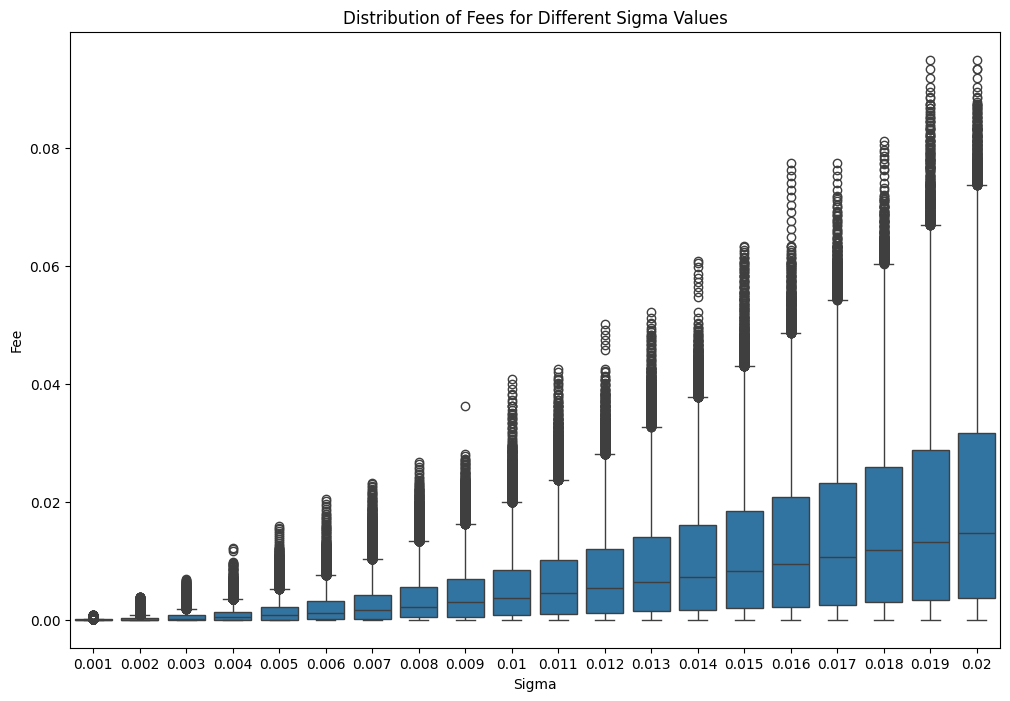

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(12, 8))

# Draw the boxplot
sns.boxplot(x='sigma', y='fee', data=results)

# Set the labels and title
plt.xlabel('Sigma')
plt.ylabel('Fee')
plt.title('Distribution of Fees for Different Sigma Values')

# Show the plot
plt.show()



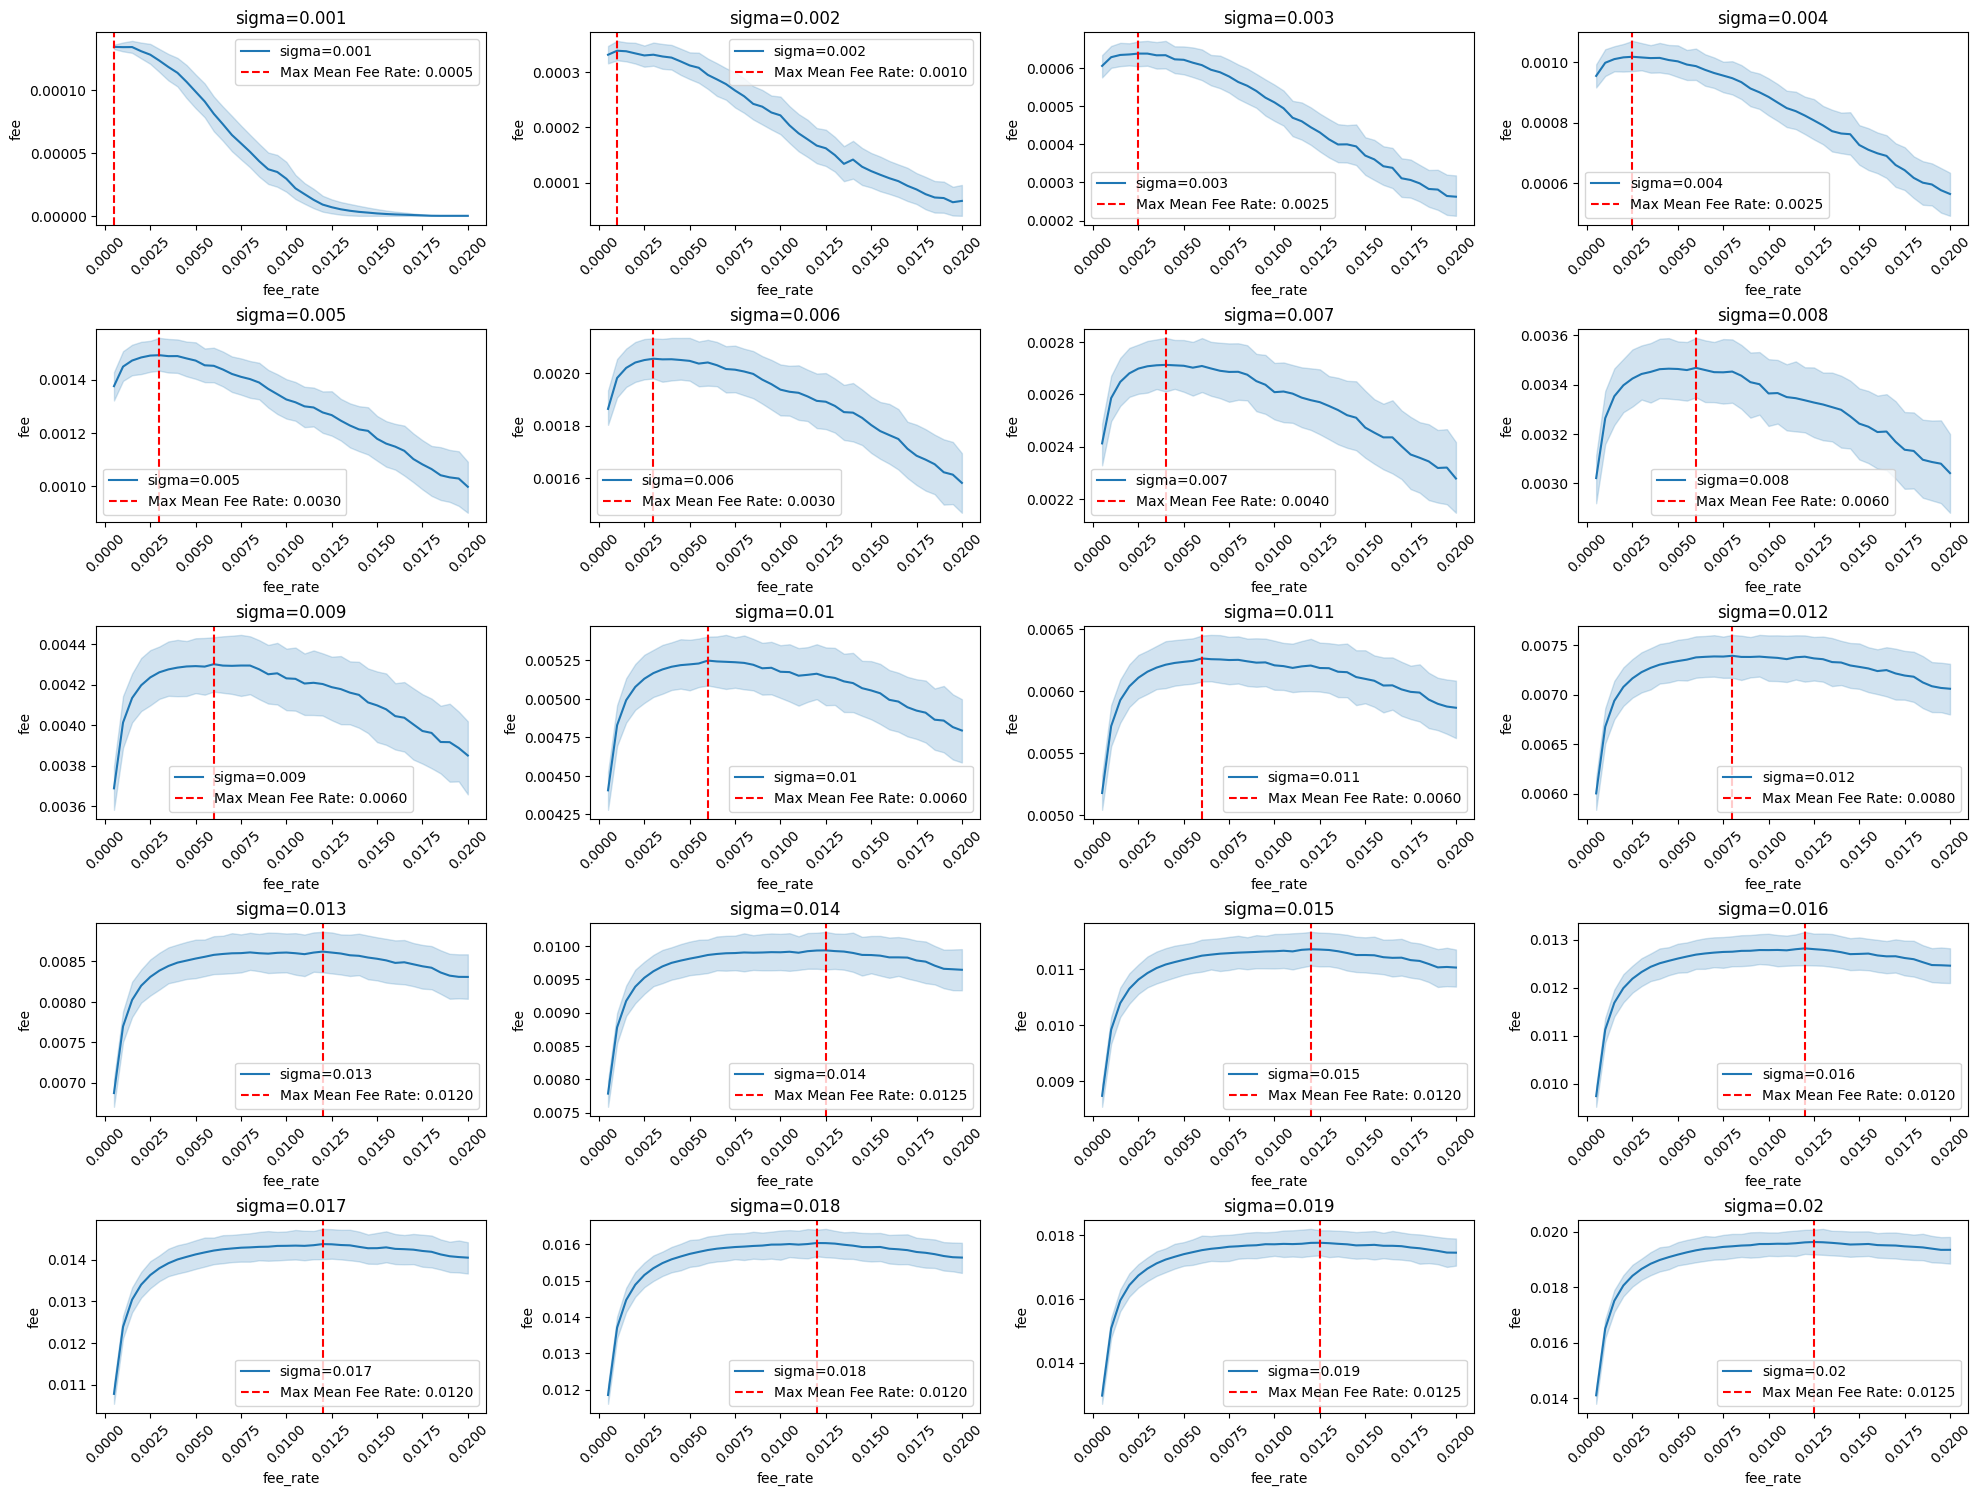

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_sigma = results['sigma'].unique()

# Define the number of rows and columns for the subplots grid
num_rows = 5
num_cols = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten the axes for easy iteration

# Loop through each sigma value and create a subplot
for i, sigma in enumerate(unique_sigma):
    df = results[results['sigma'] == sigma].copy()  # Ensure a copy to avoid warnings
    
    # Calculate the fee_rate with the highest mean fee
    max_fee_rate = df.groupby('fee_rate')['fee'].mean().idxmax()
    
    # Plot the fee vs fee_rate
    sns.lineplot(x='fee_rate', y='fee', data=df, ax=axes[i], label=f'sigma={sigma}')
    
    # Add a red dashed line to indicate the fee_rate with the highest mean fee
    axes[i].axvline(x=max_fee_rate, color='red', linestyle='--', label=f'Max Mean Fee Rate: {max_fee_rate:.4f}')
    
    # Set labels and title
    axes[i].set_xlabel('fee_rate')
    axes[i].set_ylabel('fee')
    
    # make x tick labels more readable rotate 45 degrees
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_title(f'sigma={sigma}')
    axes[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Statistics Analysis

1. **Confidence Metric Calculation**:
   - Perform **pairwise ANOVA** between the **max mean fee rate** and all other fee rates.
   - The **confidence metric** is calculated as:
     $$
     \text{Confidence Metric} = \frac{1}{\sum \text{p-values from pairwise comparisons}}
     $$
   - This metric quantifies how confidently the max mean fee rate differs from other fee rates.

2. **ANOVA p-value Heatmap**:
   - Use a **heatmap** to visualize the p-values from ANOVA for all fee rates for each sigma.
   - Each subplot in the grid represents the pairwise p-values for a different sigma value, providing insight into how fee rates compare statistically.

3. **Pairwise T-Test Heatmap**:
   - Perform **pairwise t-tests** between all fee rates for each sigma.
   - Generate a **heatmap** for each sigma to display the p-values from the t-tests, indicating the significance of differences between fee rates.


**I. Confidence Metric**

/home/shiftpub/miniconda3/envs/amm-env/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/shiftpub/miniconda3/envs/amm-env/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/shiftpub/miniconda3/envs/amm-env/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/shiftpub/miniconda3/envs/amm-env/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=se

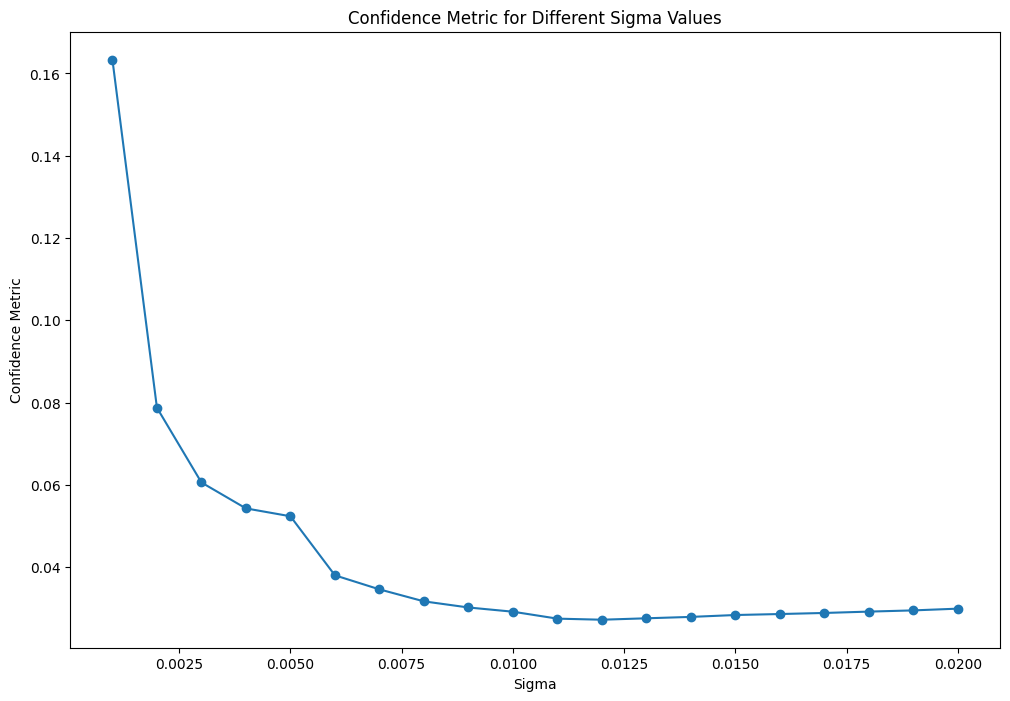

In [50]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

confidence_scores = []

def calculate_confidence(tukey_summary, max_fee_rate):
    confidence_sum = 0
    for result in tukey_summary.summary().data[1:]:
        fee_rate_1, fee_rate_2, p_value = result[0], result[1], result[4]
        if max_fee_rate in [fee_rate_1, fee_rate_2]:
            confidence_sum += p_value
    
    # Higher confidence means lower p-values
    return 1 / confidence_sum if confidence_sum > 0 else 0

for sigma in unique_sigma:
    df_sigma = results[results['sigma'] == sigma].copy()
    max_fee_rate = df_sigma.groupby('fee_rate')['fee'].mean().idxmax()
    # Perform ANOVA
    model = ols('fee ~ C(fee_rate)', data=df_sigma).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    # Perform Tukey's HSD for pairwise comparison
    tukey = pairwise_tukeyhsd(endog=df_sigma['fee'], groups=df_sigma['fee_rate'], alpha=0.05)
    confidence_scores.append(calculate_confidence(tukey, max_fee_rate))
    

# Plot the confidence scores
plt.figure(figsize=(12, 8))
plt.plot(unique_sigma, confidence_scores, marker='o')
plt.xlabel('Sigma')
plt.ylabel('Confidence Metric')
plt.title('Confidence Metric for Different Sigma Values')
plt.show()

    

**II. ANOVA p-value Heatmap**

/home/shiftpub/miniconda3/envs/amm-env/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/shiftpub/miniconda3/envs/amm-env/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/shiftpub/miniconda3/envs/amm-env/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/shiftpub/miniconda3/envs/amm-env/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=se

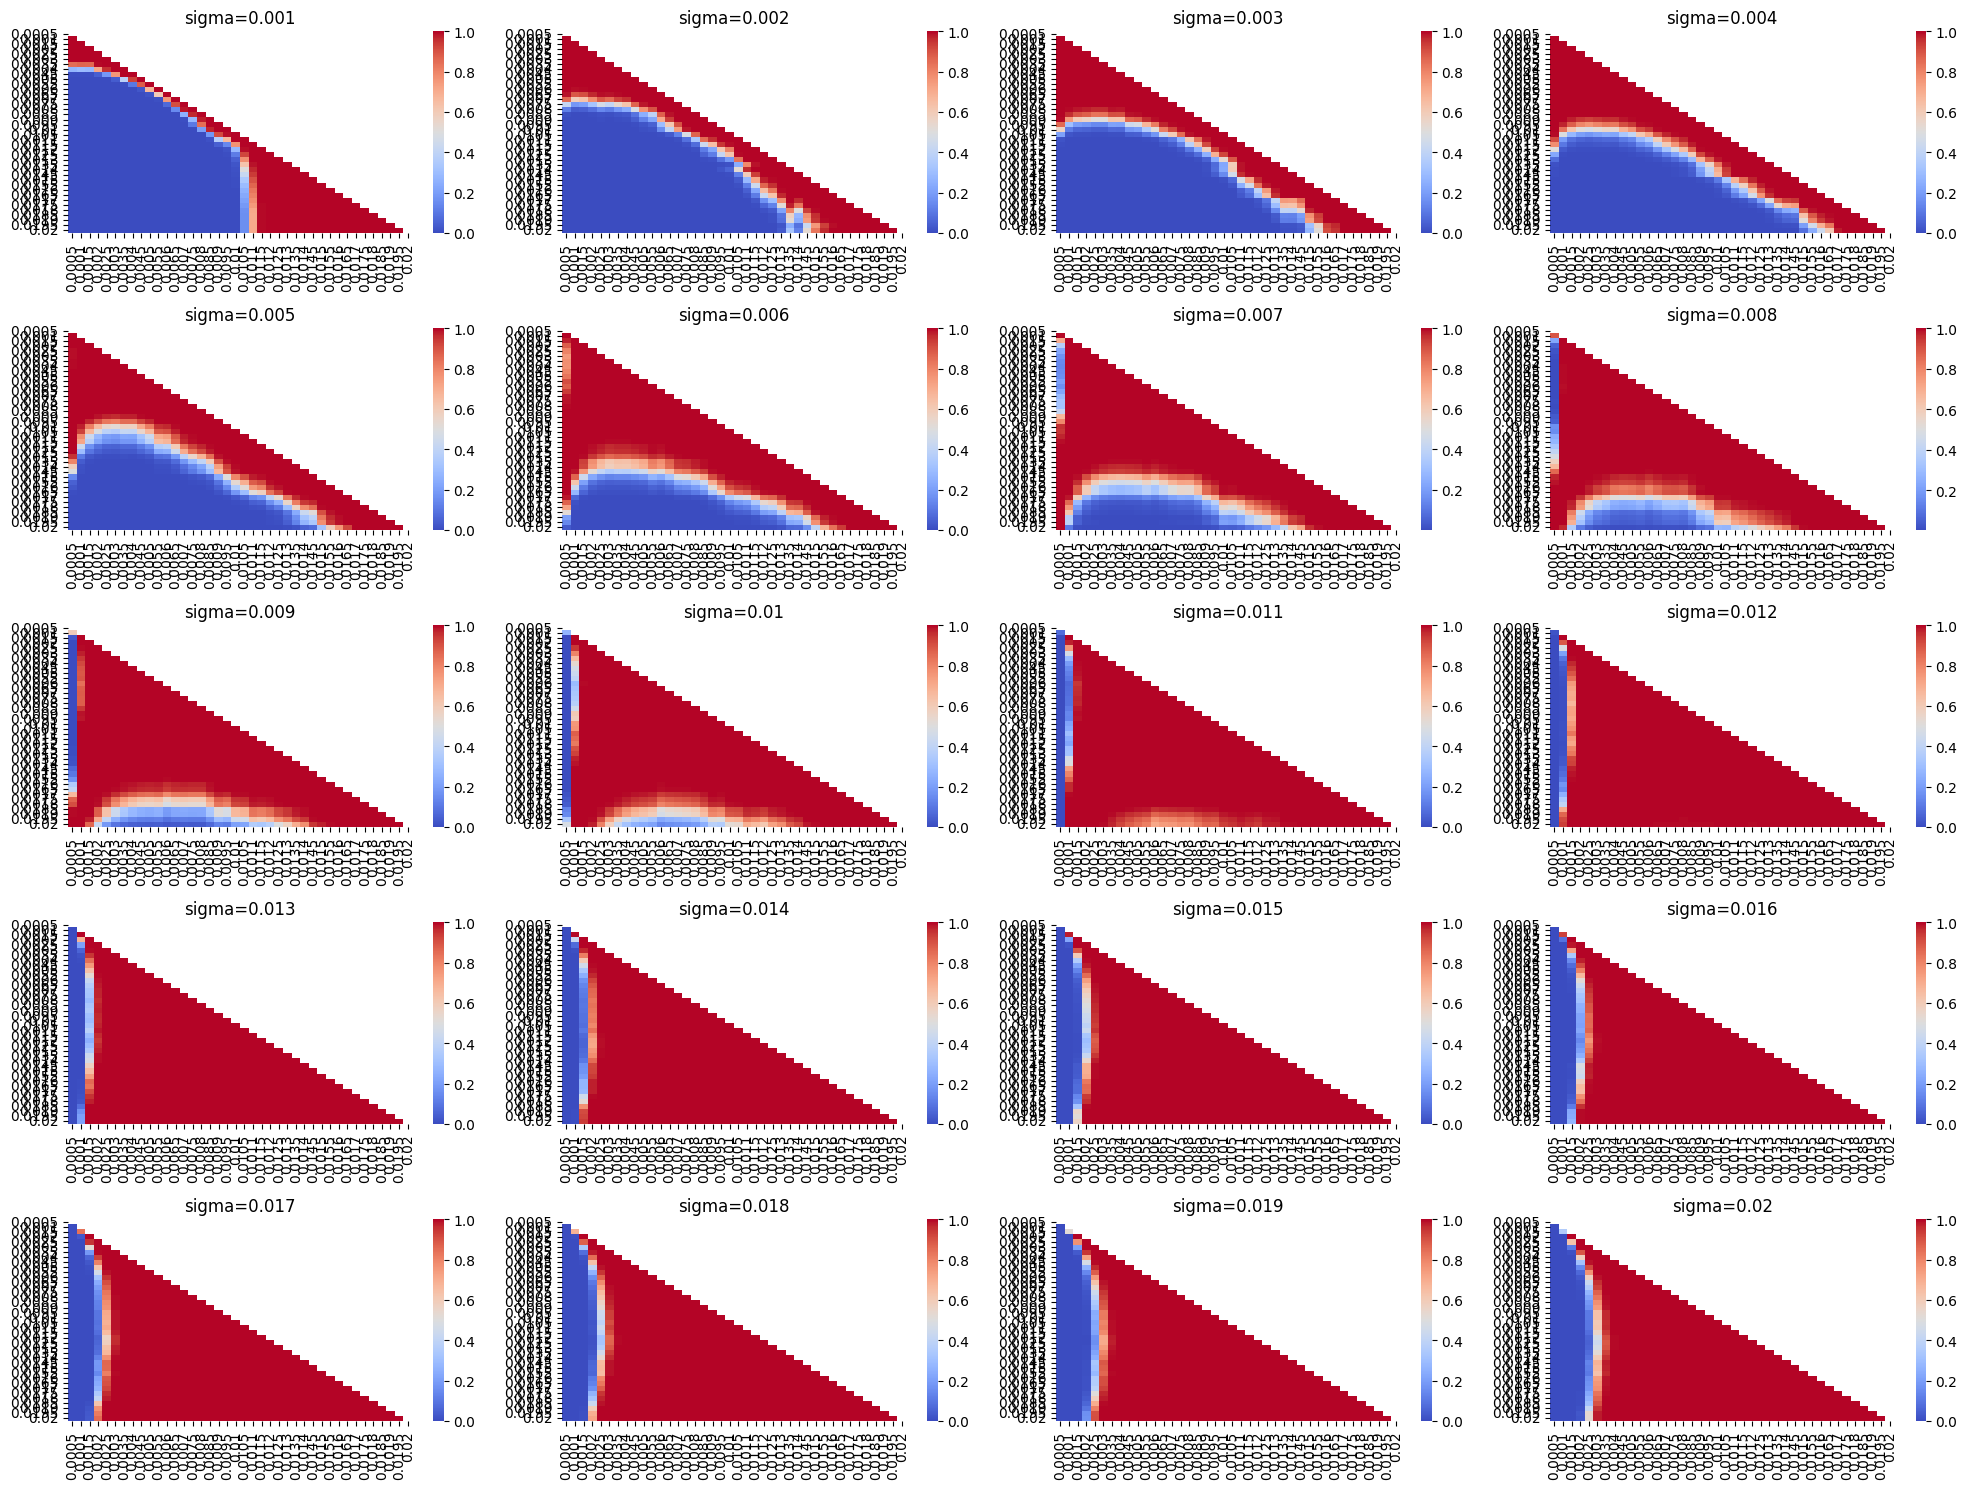

In [46]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Unique sigma values
unique_sigma = results['sigma'].unique()

# Define the number of rows and columns for the subplots grid
num_rows = 5
num_cols = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten the axes for easy iteration

# Loop through each sigma value and create a heatmap subplot for each
for i, sigma in enumerate(unique_sigma):
    df = results[results['sigma'] == sigma].copy()  # Filter the dataframe for the current sigma
    
    # Perform ANOVA
    model = ols('fee ~ C(fee_rate)', data=df).fit()
    
    # Perform Tukey's HSD for pairwise comparison
    tukey = pairwise_tukeyhsd(endog=df['fee'], groups=df['fee_rate'], alpha=0.05)
    
    # Extract unique fee rates
    fee_rates = sorted(df['fee_rate'].unique())
    
    # Create an empty matrix to store p-values
    p_value_matrix = np.ones((len(fee_rates), len(fee_rates)))  # Initialize with ones
    
    # Fill the matrix with p-values from Tukey's HSD
    for row in tukey.summary().data[1:]:
        group1, group2, meandiff, p_adj, lower, upper, reject = row
        idx1 = fee_rates.index(float(group1))
        idx2 = fee_rates.index(float(group2))
        p_value_matrix[idx1, idx2] = p_adj
        p_value_matrix[idx2, idx1] = p_adj  # Fill symmetrically
    
    # Mask the lower triangle (including the diagonal)
    mask = np.triu(np.ones_like(p_value_matrix, dtype=bool))
    
    # Plot the heatmap in the current subplot
    sns.heatmap(p_value_matrix, xticklabels=fee_rates, yticklabels=fee_rates, cmap='coolwarm', annot=False, mask=mask, ax=axes[i])
    
    # Set title for each subplot
    axes[i].set_title(f'sigma={sigma}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


**III. Pairwise T-Test Heatmap**

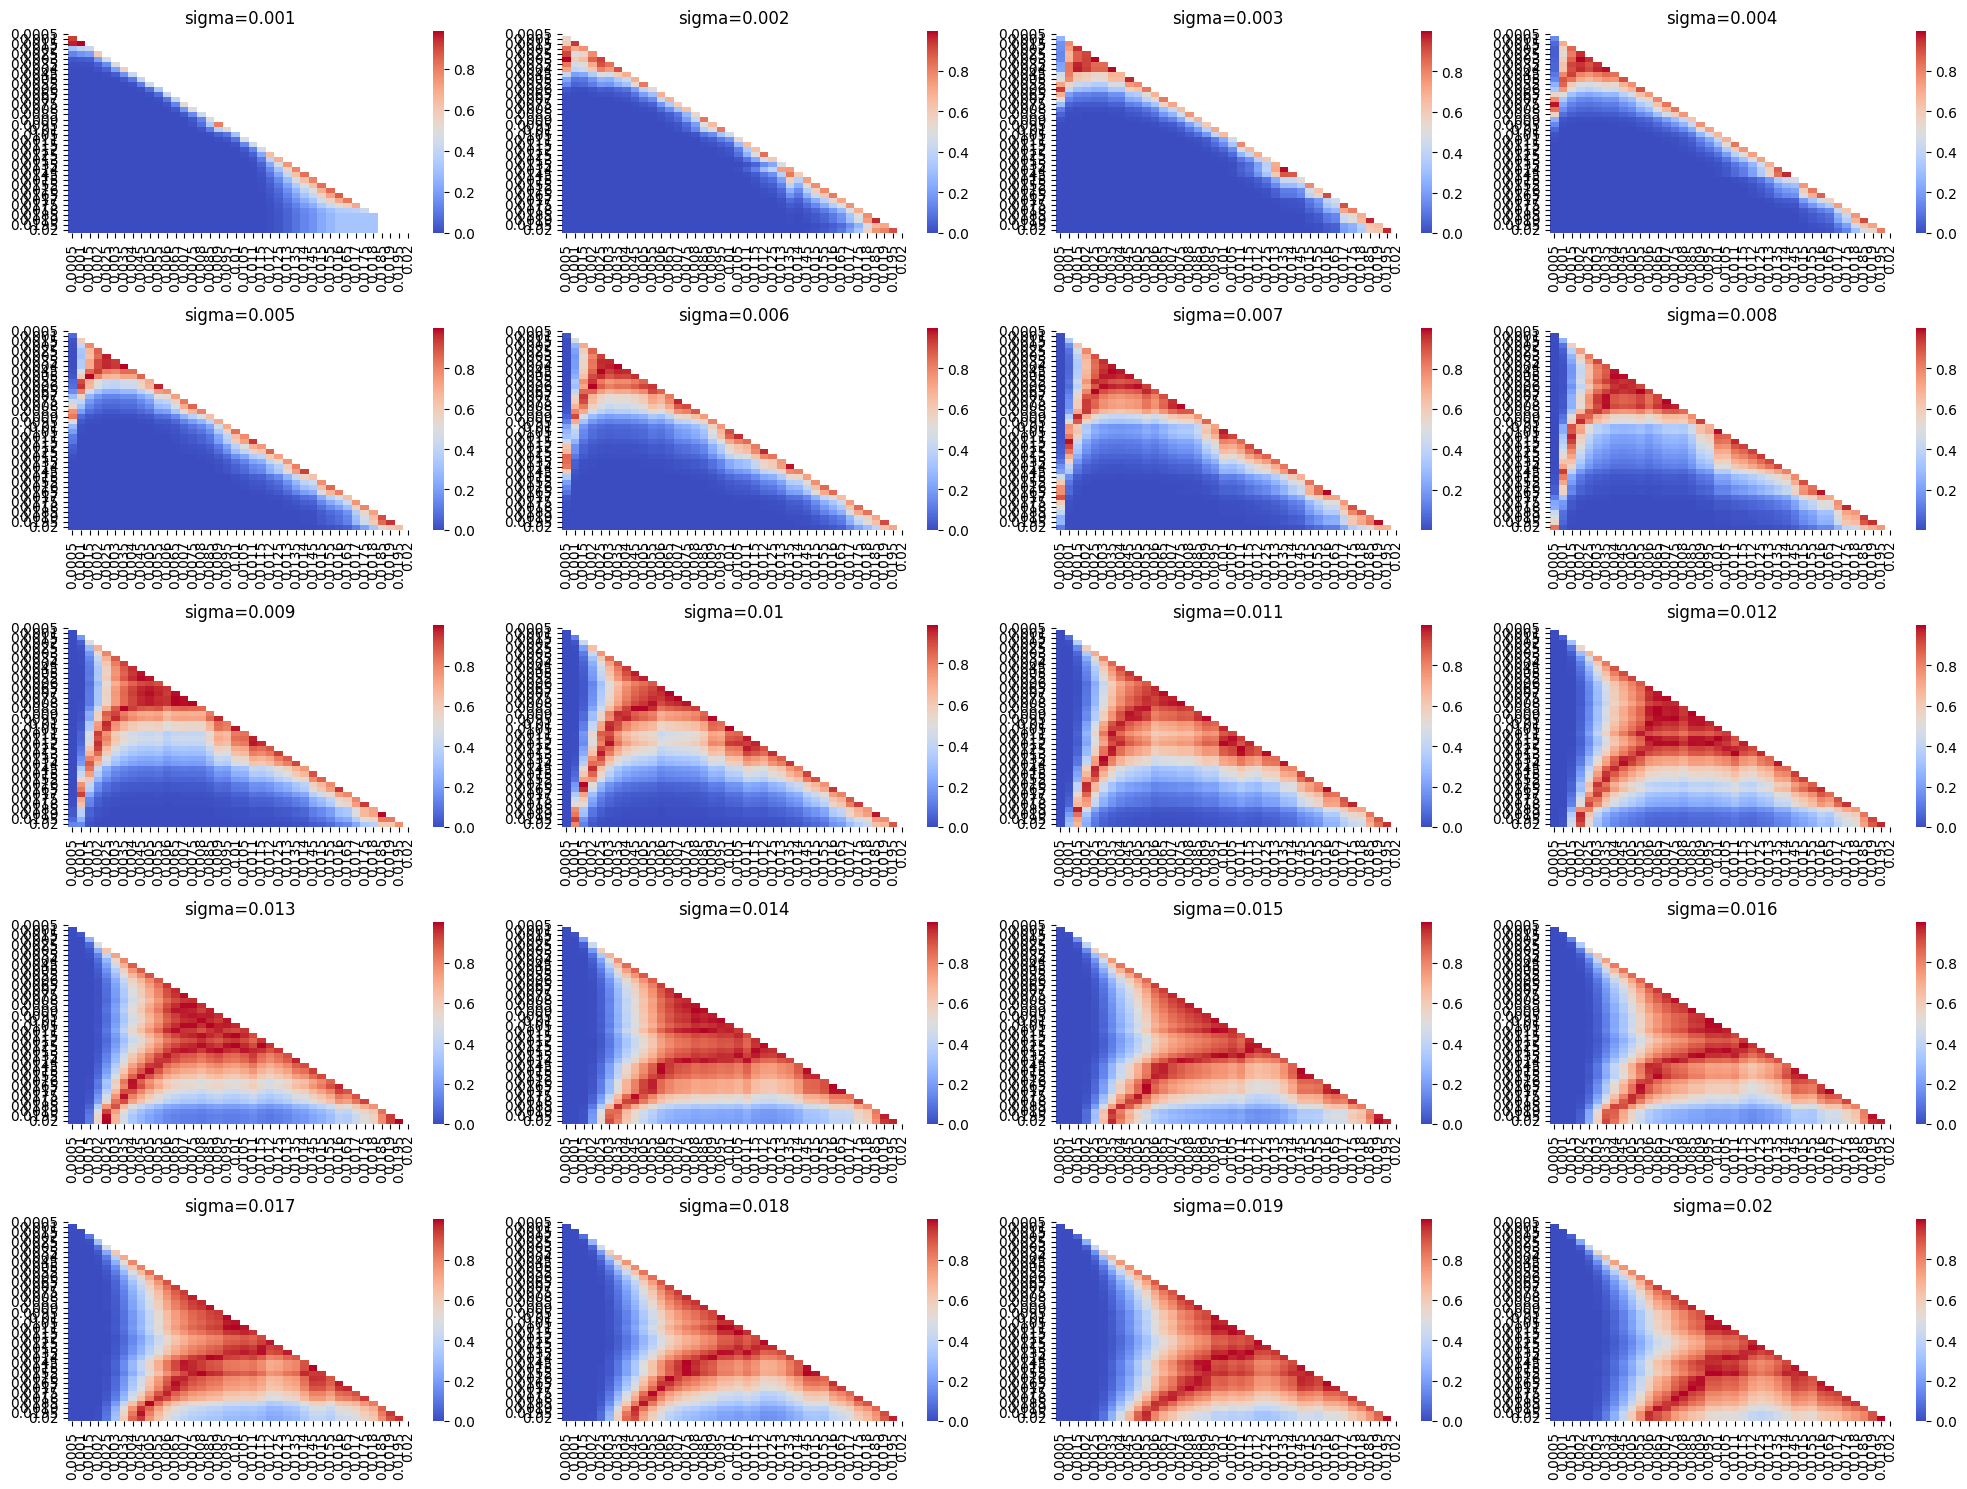

In [51]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Unique sigma values
unique_sigma = results['sigma'].unique()

# Define the number of rows and columns for the subplots grid
num_rows = 5
num_cols = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten the axes for easy iteration

# Loop through each sigma value and create a heatmap subplot for each
for i, sigma in enumerate(unique_sigma):
    df = results[results['sigma'] == sigma].copy()  # Filter the dataframe for the current sigma
    
    # Extract unique fee rates
    fee_rates = sorted(df['fee_rate'].unique())
    
    # Create an empty matrix to store p-values
    p_value_matrix = np.ones((len(fee_rates), len(fee_rates)))  # Initialize with ones
    
    # Perform pairwise t-tests for each pair of fee rates
    for idx1, fee_rate_1 in enumerate(fee_rates):
        for idx2, fee_rate_2 in enumerate(fee_rates):
            if idx1 != idx2:
                # Extract the fees for the two fee rates
                fees_1 = df[df['fee_rate'] == fee_rate_1]['fee']
                fees_2 = df[df['fee_rate'] == fee_rate_2]['fee']
                
                # Perform t-test
                t_stat, p_value = ttest_ind(fees_1, fees_2, equal_var=False)  # Assume unequal variances
                
                # Store the p-value in the matrix
                p_value_matrix[idx1, idx2] = p_value
    
    # Mask the lower triangle (including the diagonal)
    mask = np.triu(np.ones_like(p_value_matrix, dtype=bool))
    
    # Plot the heatmap in the current subplot
    sns.heatmap(p_value_matrix, xticklabels=fee_rates, yticklabels=fee_rates, cmap='coolwarm', annot=False, mask=mask, ax=axes[i])
    
    # Set title for each subplot
    axes[i].set_title(f'sigma={sigma}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


### Linear Regression : Max Mean fee rate VS. Sigma

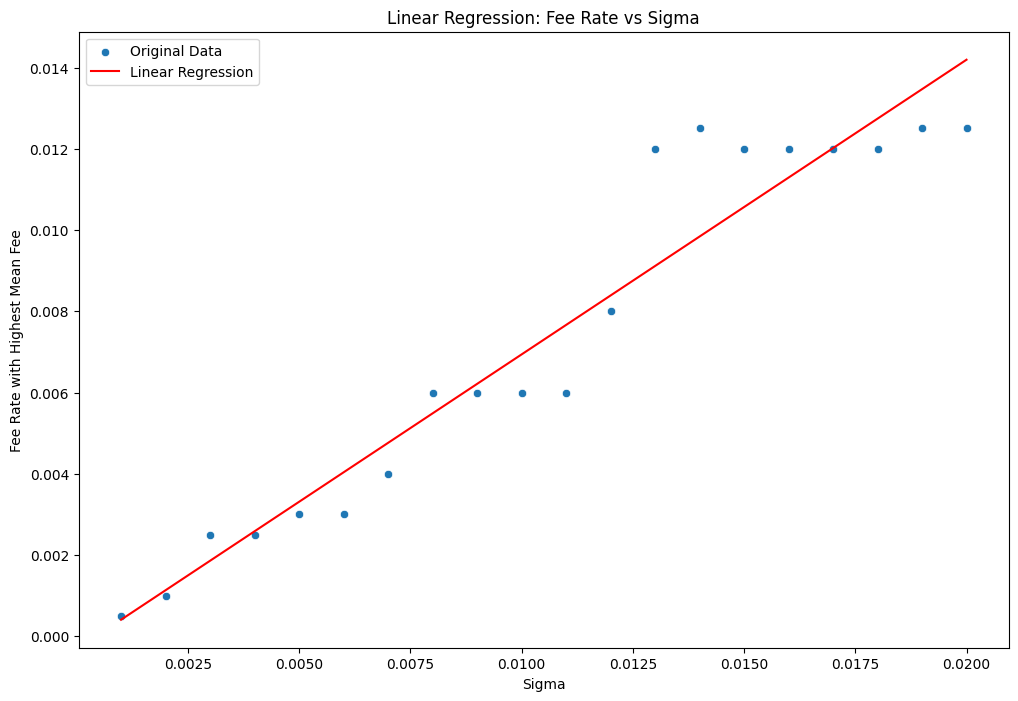

Linear Regression R^2: 0.9244377778351344
Linear Regression Coefficients: [0.72556391]
Linear Regression Intercept: -0.00031842105263157894


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# List to store sigma and corresponding fee_rate with highest mean fee
sigma_values = []
max_fee_rates = []

# Loop through each sigma
for sigma in unique_sigma:
    df = results[results['sigma'] == sigma].copy()  # Filter the dataframe for current sigma
    
    # Calculate the fee_rate with the highest mean fee for this sigma
    max_fee_rate = df.groupby('fee_rate')['fee'].mean().idxmax()
    
    # Store the sigma and the corresponding max fee_rate
    sigma_values.append(sigma)
    max_fee_rates.append(max_fee_rate)

# Prepare the data (assuming you already have sigma_values and max_fee_rates lists)
plot_data = pd.DataFrame({'sigma': sigma_values, 'max_fee_rate': max_fee_rates})

# Features and target
X = plot_data[['sigma']]  # Independent variable
y = plot_data['max_fee_rate']  # Dependent variable

# Initialize and fit the linear model
linear_model = LinearRegression()
linear_model.fit(X, y)

# Make predictions
y_pred_linear = linear_model.predict(X)

# Plot the original data
plt.figure(figsize=(12, 8))
sns.scatterplot(x='sigma', y='max_fee_rate', data=plot_data, label='Original Data')

# Plot Linear Regression line
plt.plot(plot_data['sigma'], y_pred_linear, label='Linear Regression', color='red')

# Set labels and title
plt.xlabel('Sigma')
plt.ylabel('Fee Rate with Highest Mean Fee')
plt.title('Linear Regression: Fee Rate vs Sigma')
plt.legend()

# Show the plot
plt.show()

# Print performance metrics
print("Linear Regression R^2:", r2_score(y, y_pred_linear))
print("Linear Regression Coefficients:", linear_model.coef_)
print("Linear Regression Intercept:", linear_model.intercept_)


/home/shiftpub/miniconda3/envs/amm-env/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/shiftpub/miniconda3/envs/amm-env/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/shiftpub/miniconda3/envs/amm-env/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/shiftpub/miniconda3/envs/amm-env/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=se

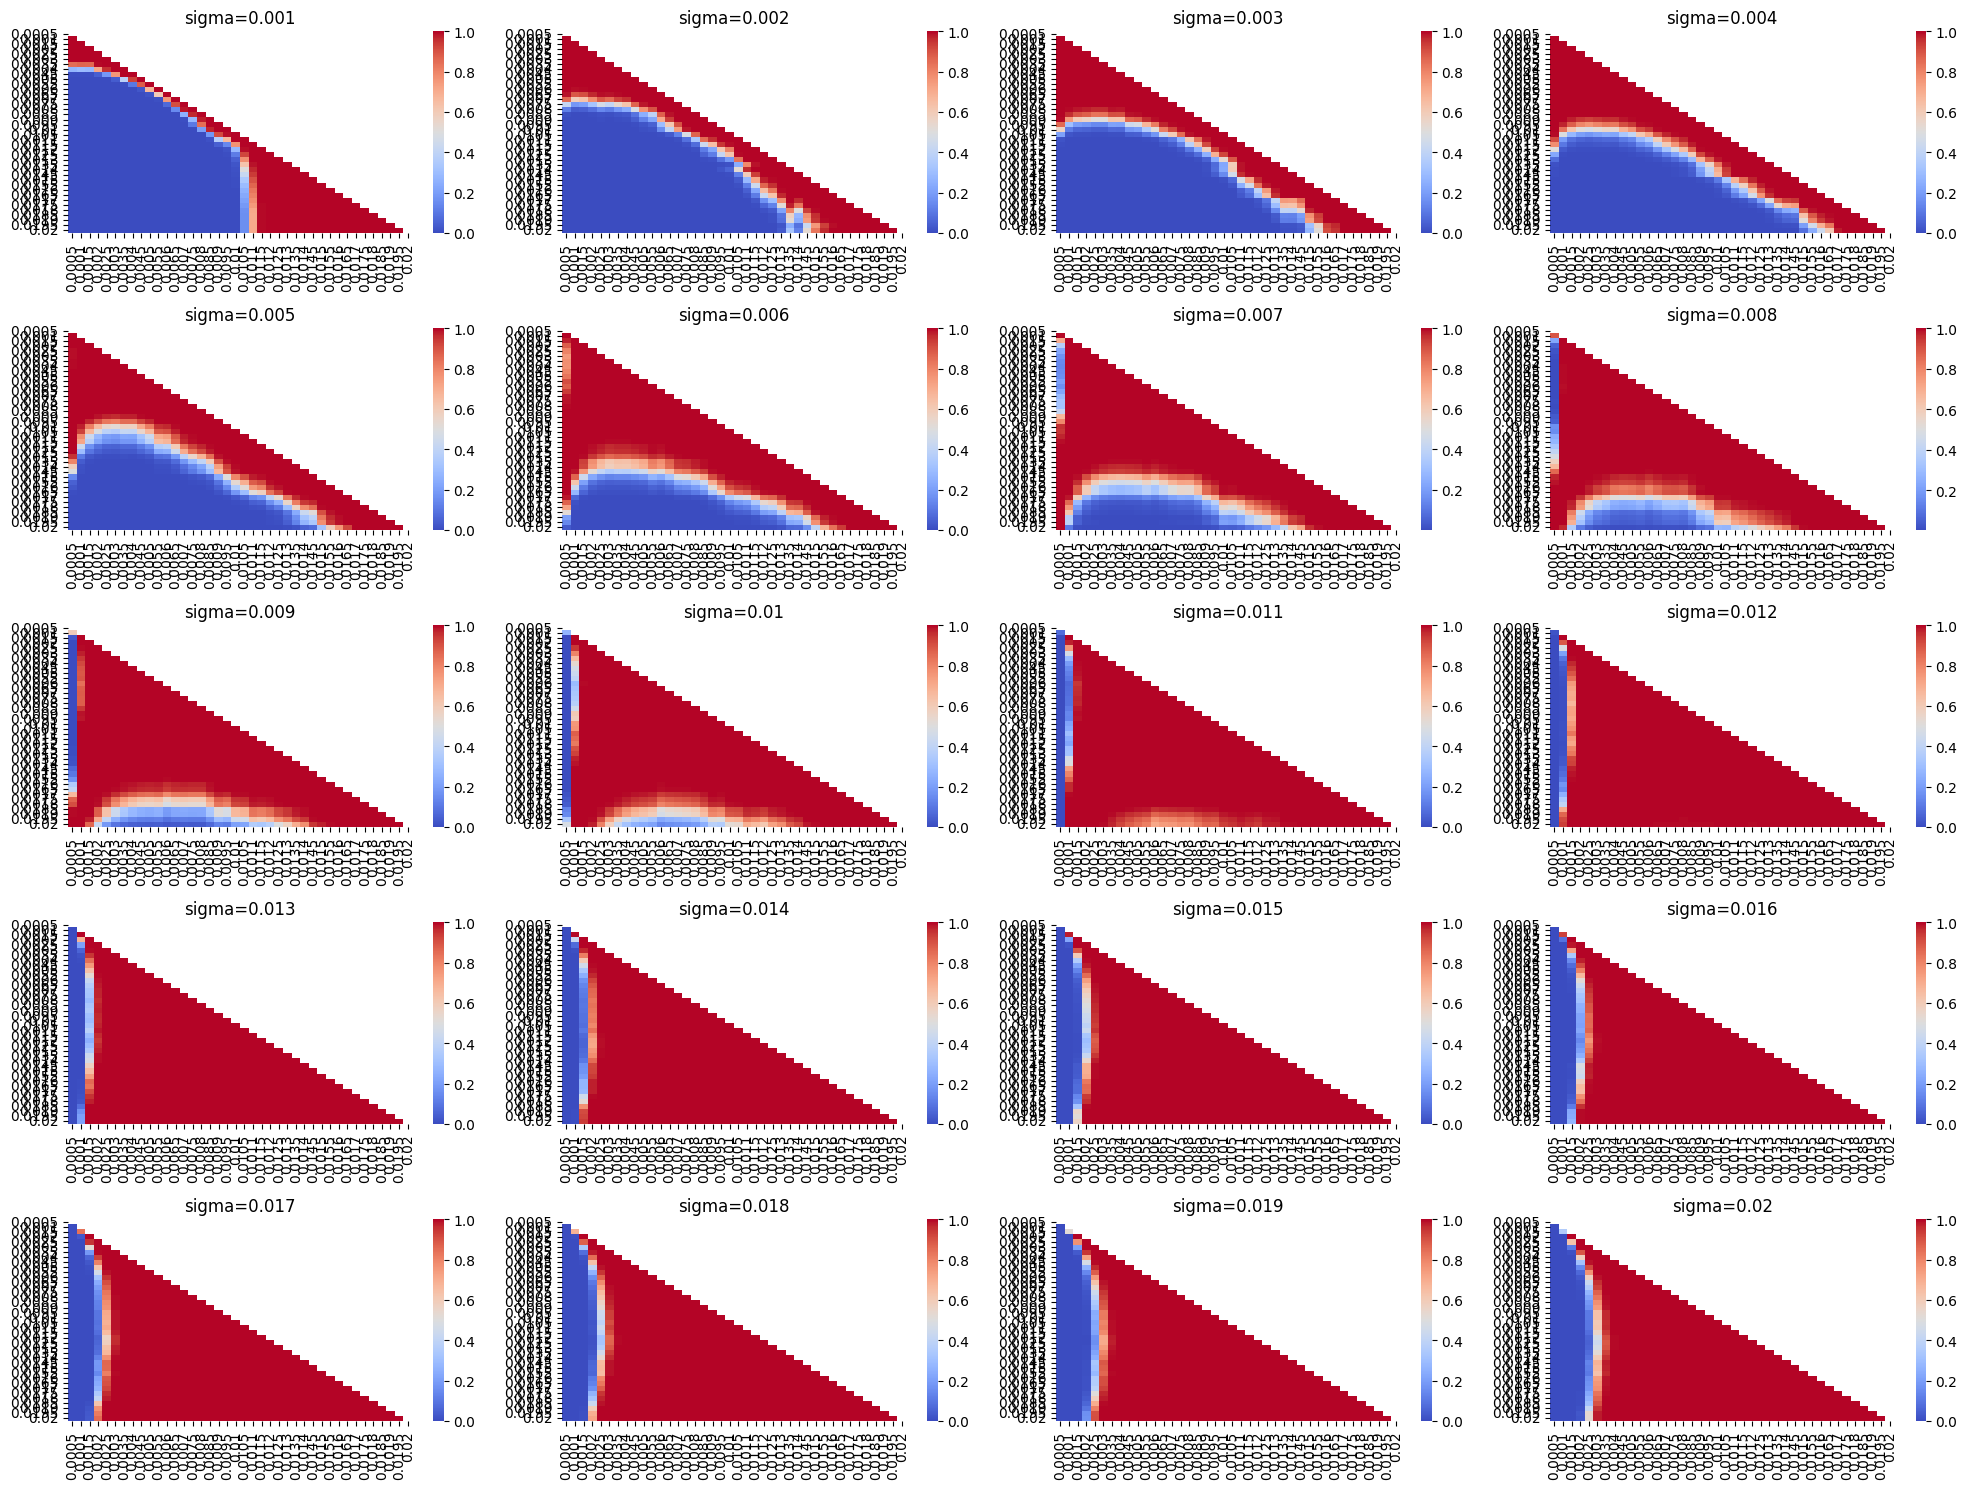

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Unique sigma values
unique_sigma = results['sigma'].unique()

# Define the number of rows and columns for the subplots grid
num_rows = 5
num_cols = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten the axes for easy iteration

# Loop through each sigma value and create a heatmap subplot for each
for i, sigma in enumerate(unique_sigma):
    df = results[results['sigma'] == sigma].copy()  # Filter the dataframe for the current sigma
    
    # Perform ANOVA
    model = ols('fee ~ C(fee_rate)', data=df).fit()
    
    # Perform Tukey's HSD for pairwise comparison
    tukey = pairwise_tukeyhsd(endog=df['fee'], groups=df['fee_rate'], alpha=0.05)
    
    # Extract unique fee rates
    fee_rates = sorted(df['fee_rate'].unique())
    
    # Create an empty matrix to store p-values
    p_value_matrix = np.ones((len(fee_rates), len(fee_rates)))  # Initialize with ones
    
    # Fill the matrix with p-values from Tukey's HSD
    for row in tukey.summary().data[1:]:
        group1, group2, meandiff, p_adj, lower, upper, reject = row
        idx1 = fee_rates.index(float(group1))
        idx2 = fee_rates.index(float(group2))
        p_value_matrix[idx1, idx2] = p_adj
        p_value_matrix[idx2, idx1] = p_adj  # Fill symmetrically
    
    # Mask the lower triangle (including the diagonal)
    mask = np.triu(np.ones_like(p_value_matrix, dtype=bool))
    
    # Plot the heatmap in the current subplot
    sns.heatmap(p_value_matrix, xticklabels=fee_rates, yticklabels=fee_rates, cmap='coolwarm', annot=False, mask=mask, ax=axes[i])
    
    # Set title for each subplot
    axes[i].set_title(f'sigma={sigma}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [5]:
# download SP500 daily data in from 2020-01-01 to 2024-10-01 from yahoo finance
import yfinance as yf
import pandas as pd

# Download SP500 data from Yahoo Finance
spy = yf.download('SPY', start='2020-01-01', end='2024-10-01')


[*********************100%***********************]  1 of 1 completed


In [6]:
print(spy.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02  323.540009  324.890015  322.529999  324.869995  302.208649   
2020-01-03  321.160004  323.640015  321.100006  322.410004  299.920258   
2020-01-06  320.489990  323.730011  320.359985  323.640015  301.064453   
2020-01-07  323.019989  323.540009  322.239990  322.730011  300.217834   
2020-01-08  322.940002  325.779999  322.670013  324.450012  301.817963   

              Volume  
Date                  
2020-01-02  59151200  
2020-01-03  77709700  
2020-01-06  55653900  
2020-01-07  40496400  
2020-01-08  68296000  


In [7]:
print(spy.tail())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-09-24  570.479980  571.359985  567.599976  571.299988  571.299988   
2024-09-25  571.140015  571.890015  568.909973  570.039978  570.039978   
2024-09-26  574.380005  574.710022  569.900024  572.299988  572.299988   
2024-09-27  573.390015  574.219971  570.419983  571.469971  571.469971   
2024-09-30  570.419983  574.380005  568.080017  573.760010  573.760010   

              Volume  
Date                  
2024-09-24  46805700  
2024-09-25  38428600  
2024-09-26  48336000  
2024-09-27  42100900  
2024-09-30  63557400  


In [9]:
# calculate the daily returns and volatility
spy['daily_return'] = spy['Adj Close'].pct_change()
spy['volatility'] = spy['daily_return'].rolling(window=20).std()
spy['annualized_volatility'] = spy['volatility'] * (252 ** 0.5)

Text(0.5, 1.0, 'Distribution of Annualized Volatility for SPY (2020-2024)')

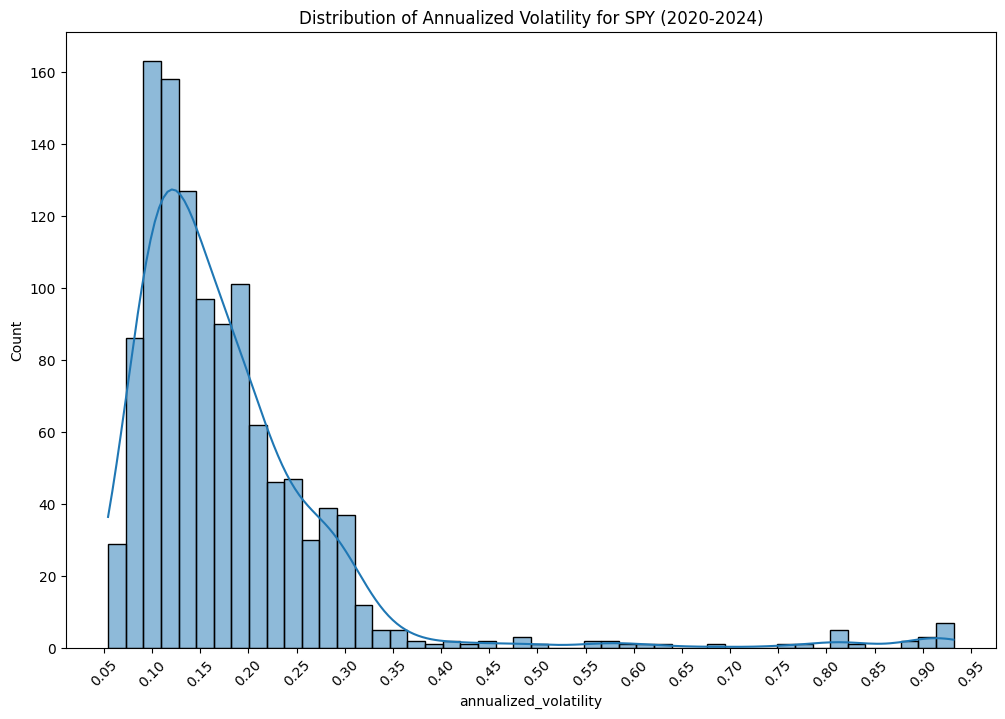

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns   
# draw a histogram of the annualized volatility
plt.figure(figsize=(12, 8))
sns.histplot(spy['annualized_volatility'].dropna(), kde=True)
plt.xticks(rotation=45)
# increase number of ticks on x-axis
plt.locator_params(axis='x', nbins=20)
plt.title('Distribution of Annualized Volatility for SPY (2020-2024)')

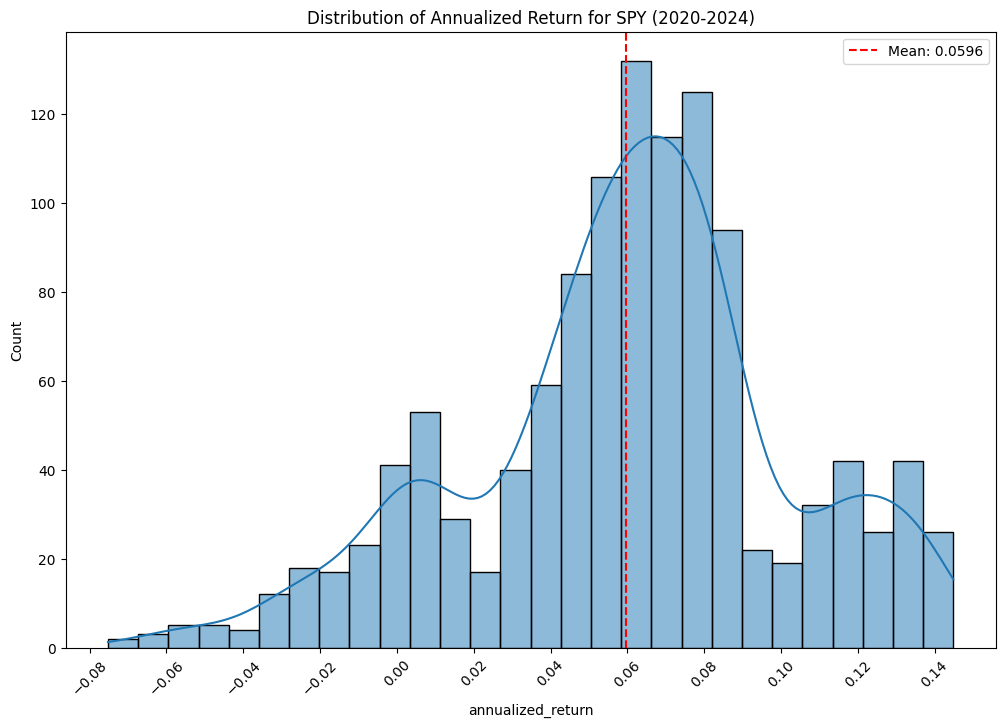

In [26]:
# calculate the anualized return
spy['annualized_return'] = (1 + spy['daily_return']).cumprod() ** (252 / len(spy)) - 1

# draw a histogram of the annualized return
plt.figure(figsize=(12, 8))
sns.histplot(spy['annualized_return'].dropna(), kde=True)
plt.xticks(rotation=45)
# increase number of ticks on x-axis
plt.locator_params(axis='x', nbins=20)
plt.title('Distribution of Annualized Return for SPY (2020-2024)')
# add a vertical line on the mean and write it in the legend
plt.axvline(spy['annualized_return'].mean(), color='red', linestyle='--', label=f'Mean: {spy["annualized_return"].mean():.4f}')
plt.legend()    

plt.show()



In [20]:
# calculate how many second in 20 trading days
import datetime
trading_days = 20
start_date = '2020-01-01'
end_date = '2024-10-01'
start_datetime = datetime.datetime.strptime(start_date, '%Y-%m-%d')
end_datetime = datetime.datetime.strptime(end_date, '%Y-%m-%d')
total_seconds = (end_datetime - start_datetime).total_seconds()
seconds_in_trading_days = total_seconds / (252 * 7 * trading_days)
print(seconds_in_trading_days)

4248.9795918367345


In [21]:
390 * 60 * 20

468000

In [22]:
390*20

7800